In [3]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle

In [4]:
data = np.load("../data/swiss_roll.npy")
data_phate = np.load("../data/swiss_roll_phate.npy")

In [5]:
initialize(config_path="../conf")
cfg = compose(config_name="config")

/tmp/ipykernel_4140353/3685438452.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../conf")


In [6]:
cfg

{'logger': {'use_wandb': True, 'entity': 'xingzhis', 'project': 'dmae', 'tags': ['default']}, 'model': {'log_dist': True, 'layer_widths': [64, 64, 64], 'lr': 0.001, 'activation': 'relu', 'dist_reconstr_weights': [0.5, 0.5, 0.0]}, 'data': {'batch_size': 1024, 'file_type': 'npy', 'datapath': '../data/swiss_roll.npy', 'phatepath': '../data/swiss_roll_phate.npy', 'adata_phate_name': 'X_phate', 'require_phate': False, 'phate_dim': 2}, 'training': {'max_epochs': 50, 'patience': 10, 'monitor': 'val_loss', 'accelerator': 'cuda', 'log_every_n_steps': 100}, 'phate': {'random_state': 42, 'knn': 4, 'decay': 15, 't': 12, 'n_jobs': -2}, 'path': {'save': True, 'root': '../results/', 'model': 'model', 'procrustes': 'procrustes', 'plots': '', 'log': '', 'out_data': ''}}

In [7]:
if cfg.model.activation == 'relu':
    activation_fn = torch.nn.ReLU()
elif cfg.model.activation == 'leaky_relu':
    activation_fn = torch.nn.LeakyReLU()
elif cfg.model.activation == 'sigmoid':
    activation_fn = torch.nn.Sigmoid()
else:
    raise ValueError('Unknown activation function')
ckpt_path = '../res_swiss_roll/model.ckpt'
model = AEDist.load_from_checkpoint(
    ckpt_path,
    dim=data.shape[1],
    emb_dim=data_phate.shape[1],
    layer_widths=cfg.model.layer_widths,
    activation_fn=activation_fn,
    dist_reconstr_weights=cfg.model.dist_reconstr_weights,
    log_dist=cfg.model.log_dist,
    lr=cfg.model.lr,
)

In [8]:
with open('../res_swiss_roll/procrustes.pkl', 'rb') as file:
    procrustes = pickle.load(file)

In [9]:
X_tensor = torch.from_numpy(data).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

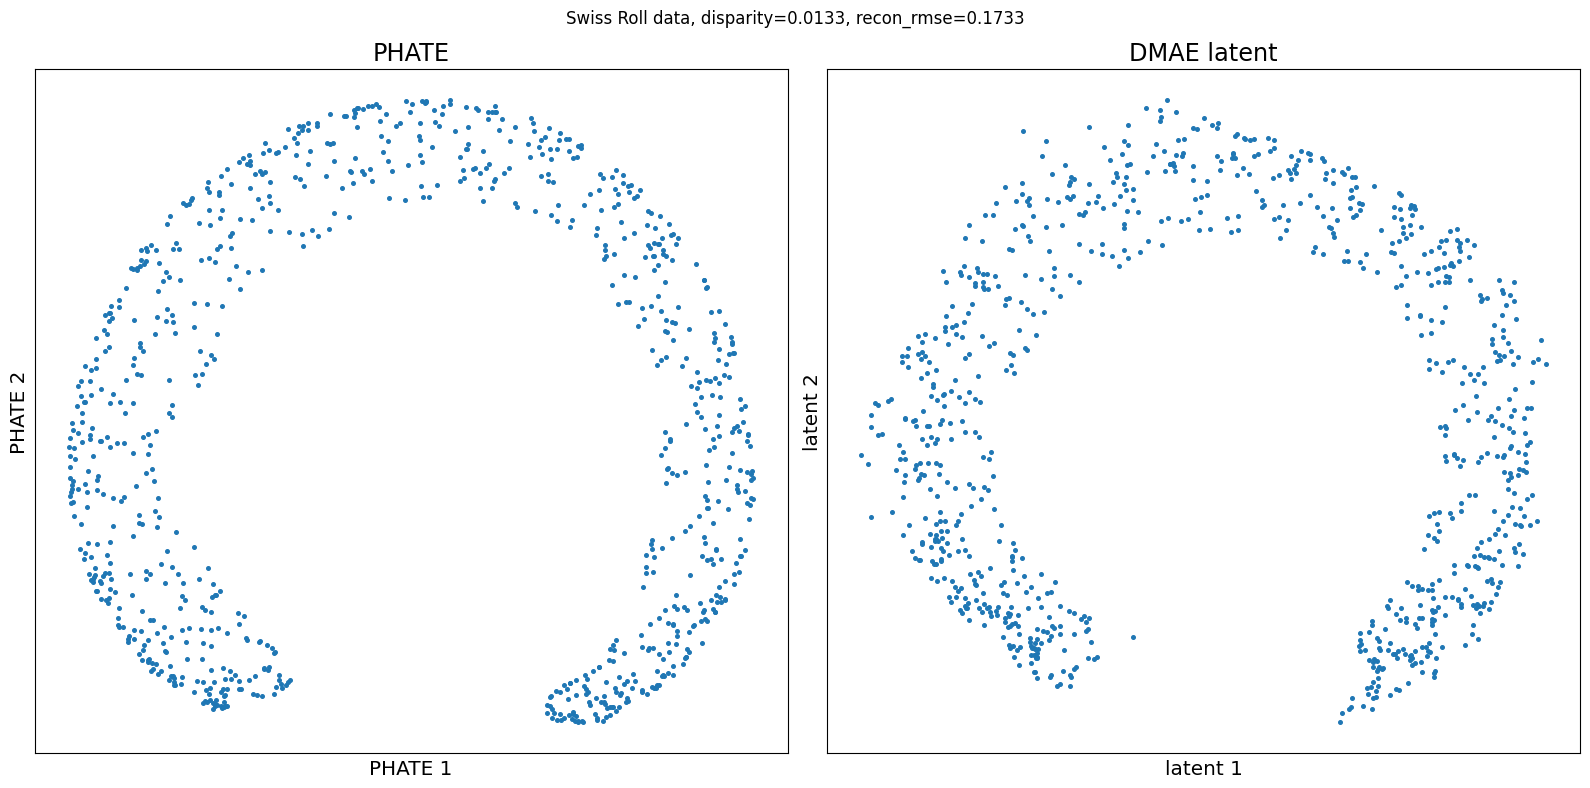

In [10]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

z_rot = procrustes.transform(z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(data_phate, ax=axes[0],
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, ax=axes[1],
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"Swiss Roll data, disparity={procrustes.disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()

In [12]:
xhat

array([[ 0.11037397, -0.49731   , -1.1358967 ],
       [ 0.10462507, -0.5043016 , -1.1364791 ],
       [ 0.24820685, -0.36880454, -1.2943135 ],
       ...,
       [ 1.2433599 , -0.3571005 ,  0.8324531 ],
       [ 1.2770642 , -0.16290538,  0.791995  ],
       [ 1.2421646 , -0.14690973,  0.95632285]], dtype=float32)

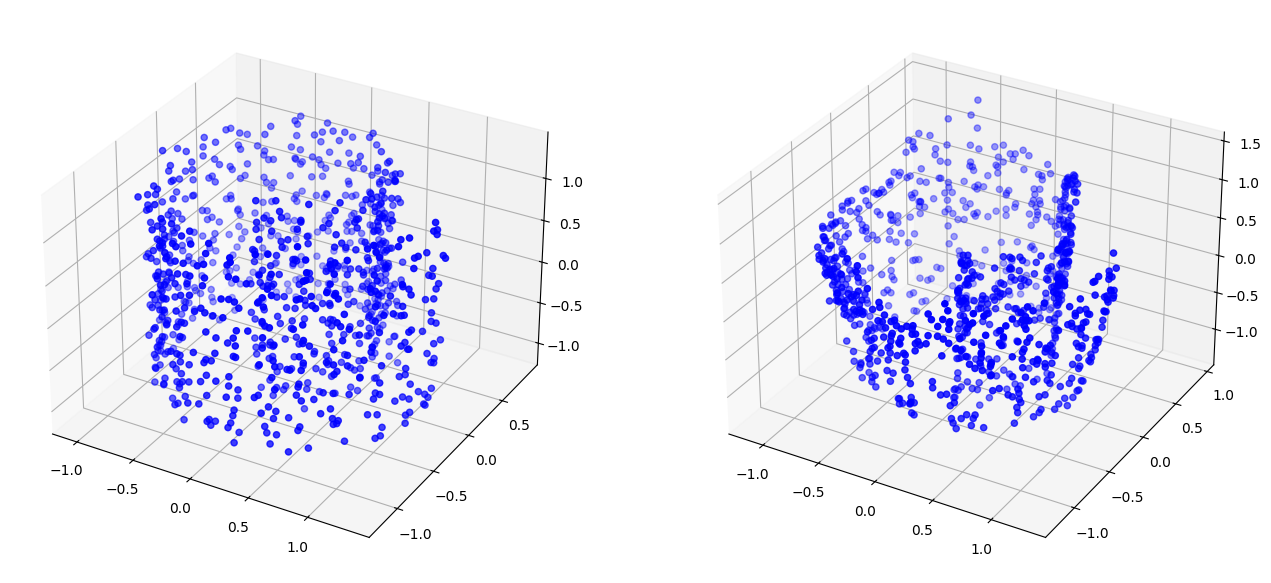

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'})

# Plot the first scatter plot
axes[0].scatter(data[:, 0], data[:, 1], data[:, 2], c='b', label='data')

# Plot the second scatter plot
axes[1].scatter(xhat[:, 0], xhat[:, 1], xhat[:, 2], c='b', label='data')

plt.show()
